In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
# Converts LTSpice to df

def ltspice_to_df(filepath: str) -> pd.DataFrame:
    """
    Converts an LTspice-exported text file to a clean pandas DataFrame.
    Works for any standard LTspice export (tab or space separated).

    Example:
    --------
    df = ltspice_to_df("export.txt")
    print(df.head())
    df.plot(x=df.columns[0], y=df.columns[1:])
    """
    df = pd.read_csv(filepath, delim_whitespace=True, comment='#')
    return df

In [3]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# # ---------- helpers ----------
# def _nice_step(raw_step: float) -> float:
#     """Round a step to a 'nice' 1–2–2.5–5–10 × 10^n."""
#     if raw_step <= 0 or not np.isfinite(raw_step):
#         return 1.0
#     exp  = np.floor(np.log10(raw_step))
#     frac = raw_step / (10**exp)
#     for m in (1, 2, 2.5, 5, 10):
#         if frac <= m:
#             return m * (10**exp)
#     return 10**(exp + 1)

# def label_every_grid(ax, target_major_ticks: int = 25) -> None:
#     """Label every grid line with adaptive 'nice' major ticks on both axes."""
#     xmin, xmax = ax.get_xlim()
#     ymin, ymax = ax.get_ylim()
#     xstep = _nice_step((xmax - xmin) / max(target_major_ticks, 2))
#     ystep = _nice_step((ymax - ymin) / max(target_major_ticks, 2))
#     ax.xaxis.set_major_locator(MultipleLocator(xstep))
#     ax.yaxis.set_major_locator(MultipleLocator(ystep))
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
#     ax.grid(True, which='major', linestyle='--', alpha=0.6)

# # ---------- generic family-of-curves plotter for MOSFET (or anything) ----------
# def plot_family_curves(
#     title: str,
#     x_label: str,
#     y_label: str,
#     df: pd.DataFrame,
#     group_col: str,      # e.g., 'vgg' (VGS)
#     x_col: str,          # e.g., 'vds'
#     y_col: str,          # e.g., 'irg' (ID in A)
#     *,
#     y_scale: float = 1.0,          # e.g., 1000 for mA
#     annotate_on_curves: bool = True,
#     target_major_ticks: int = 30,
#     marker: str = 'o',
#     markersize: float = 3,
#     linewidth: float = 1.8,
#     every_other_xtick: bool = True,   # <— new option
# ):
#     """
#     Plot a family of curves (y vs x) grouped by `group_col`.

#     Requires helper: label_every_grid(ax, target_major_ticks)
#     """
#     data = df.copy()
#     for c in [group_col, x_col, y_col]:
#         data[c] = pd.to_numeric(data[c], errors='coerce')
#     data = data.dropna(subset=[group_col, x_col, y_col]).sort_values([group_col, x_col])

#     data['_yplot'] = data[y_col] * y_scale

#     fig, ax = plt.subplots(figsize=(8, 6))

#     for gval, g in data.groupby(group_col, sort=True):
#         x = g[x_col].to_numpy()
#         y = g['_yplot'].to_numpy()
#         label = f"{group_col.upper()} = {gval:g} V"
#         ax.plot(x, y, marker=marker, markersize=markersize, linewidth=linewidth, label=label)
#         if annotate_on_curves and len(x):
#             ax.text(x[-1], y[-1], f"  {label}", va='center')

#     ax.set_title(title, fontsize=14)
#     ax.set_xlabel(x_label, fontsize=12)
#     ax.set_ylabel(y_label, fontsize=12)

#     ax.grid(True, which='both', linestyle=':', alpha=0.25)
#     label_every_grid(ax, target_major_ticks=target_major_ticks)

#     # show every other x tick (after limits are finalized)
#     if every_other_xtick:
#         xt = ax.get_xticks()
#         yt = ax.get_yticks()
#         if len(xt) > 2:
#             ax.set_xticks(xt[::2])
#         if len(yt) > 2:
#             ax.set_yticks(yt[::2])

#     if not annotate_on_curves:
#         ax.legend(fontsize=10)

#     fig.tight_layout()
#     plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# ---------- helpers (unchanged) ----------
def _nice_step(raw_step: float) -> float:
    """Round a step to a 'nice' 1–2–2.5–5–10 × 10^n."""
    if raw_step <= 0 or not np.isfinite(raw_step):
        return 1.0
    exp  = np.floor(np.log10(raw_step))
    frac = raw_step / (10**exp)
    for m in (1, 2, 2.5, 5, 10):
        if frac <= m:
            return m * (10**exp)
    return 10**(exp + 1)

def label_every_grid(ax, target_major_ticks: int = 25) -> None:
    """Label every grid line with adaptive 'nice' major ticks on both axes."""
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xstep = _nice_step((xmax - xmin) / max(target_major_ticks, 2))
    ystep = _nice_step((ymax - ymin) / max(target_major_ticks, 2))
    ax.xaxis.set_major_locator(MultipleLocator(xstep))
    ax.yaxis.set_major_locator(MultipleLocator(ystep))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.grid(True, which='major', linestyle='--', alpha=0.6)

# ---------- tiny helper for fits (new) ----------
def _polyfit_with_r2(x: np.ndarray, y: np.ndarray, degree: int = 1):
    """Return (coef, r2) for polynomial fit y = P(x). coef is np.polyfit style."""
    if x.size < degree + 1:
        return None, np.nan
    coef = np.polyfit(x, y, degree)  # highest power first
    yhat = np.polyval(coef, x)
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot != 0 else np.nan
    return coef, r2

# ---------- generic family-of-curves plotter (backwards compatible) ----------
def plot_family_curves(
    title: str,
    x_label: str,
    y_label: str,
    df: pd.DataFrame,
    group_col: str,      # e.g., 'vgg' (VGS)
    x_col: str,          # e.g., 'vds'
    y_col: str,          # e.g., 'irg' (ID in A)
    *,
    y_scale: float = 1.0,          # e.g., 1000 for mA
    annotate_on_curves: bool = True,
    target_major_ticks: int = 30,
    marker: str = 'o',
    markersize: float = 3,
    linewidth: float = 1.8,
    every_other_xtick: bool = True,

    # ---- NEW OPTIONAL ARGS (default off; won’t break old calls) ----
    add_best_fit: bool = False,    # draw fit per group if True
    fit_degree: int = 1,           # 1 = linear, 2 = quadratic, etc.
    fit_linestyle: str = '--',
    fit_linewidth: float = 2.0,
    fit_alpha: float = 0.9,
    fit_legend: bool = True,       # include fit curves in legend
    annotate_fit: bool = True,     # write eqn + R² near right edge
):
    """
    Plot a family of curves (y vs x) grouped by `group_col`.

    New behavior (only if `add_best_fit=True`):
      - Fits a polynomial (degree `fit_degree`) to each group's plotted data
      - Plots the fit using the same color as the group's data
      - Optionally annotates equation and R² at the right edge
    """
    data = df.copy()
    for c in [group_col, x_col, y_col]:
        data[c] = pd.to_numeric(data[c], errors='coerce')
    data = data.dropna(subset=[group_col, x_col, y_col]).sort_values([group_col, x_col])

    data['_yplot'] = data[y_col] * y_scale

    fig, ax = plt.subplots(figsize=(8, 6))

    # lock colors: reuse same color for data and its fit
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', None)
    color_idx = 0

    for gval, g in data.groupby(group_col, sort=True):
        x = g[x_col].to_numpy()
        y = g['_yplot'].to_numpy()
        label = f"{group_col.upper()} = {gval:g} V"

        color = None
        if color_cycle is not None:
            color = color_cycle[color_idx % len(color_cycle)]
            color_idx += 1

        ax.plot(x, y, marker=marker, markersize=markersize,
                linewidth=linewidth, label=label, color=color)

        if annotate_on_curves and len(x):
            ax.text(x[-1], y[-1], f"  {label}", va='center', color='black')

        # ---- optional best-fit line ----
        if add_best_fit and len(x) >= fit_degree + 1:
            coef, r2 = _polyfit_with_r2(x, y, degree=fit_degree)
            if coef is not None:
                xfit = np.linspace(x.min(), x.max(), 300)
                yfit = np.polyval(coef, xfit)

                fit_lbl = None
                if fit_legend:
                    if fit_degree == 1:
                        m, b = coef  # for linear: coef = [m, b]
                        fit_lbl = f"Fit ({group_col}={gval:g}): y={m:.3g}x+{b:.3g}, R²={r2:.3f}"
                    else:
                        fit_lbl = f"Fit ({group_col}={gval:g}), deg {fit_degree}, R²={r2:.3f}"

                ax.plot(xfit, yfit, linestyle=fit_linestyle, linewidth=fit_linewidth,
                        alpha=fit_alpha, color='dimgray', label=fit_lbl)

                # if annotate_fit:
                #     if fit_degree == 1:
                #         m, b = coef
                #         txt = f"{m:.3g}·x + {b:.3g}\nR²={r2:.3f}"
                #     else:
                #         terms = [f"{c:.3g}x^{fit_degree-i}" for i, c in enumerate(coef[:-1])]
                #         terms.append(f"{coef[-1]:.3g}")
                #         txt = " + ".join(terms) + f"\nR²={r2:.3f}"
                #     ax.annotate(txt, xy=(xfit[-1], yfit[-1]),
                #                 xytext=(6, 6), textcoords="offset points",
                #                 fontsize=9, color=color)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    ax.grid(True, which='both', linestyle=':', alpha=0.25)
    label_every_grid(ax, target_major_ticks=target_major_ticks)

    # show every other x/y tick (after limits are finalized)
    if every_other_xtick:
        xt = ax.get_xticks()
        yt = ax.get_yticks()
        if len(xt) > 2:
            ax.set_xticks(xt[::2])
        if len(yt) > 2:
            ax.set_yticks(yt[::2])

    # show legend if curve labels were suppressed by annotations OR fits are added
    if not annotate_on_curves or add_best_fit:
        ax.legend(fontsize=10)

    fig.tight_layout()
    plt.show()


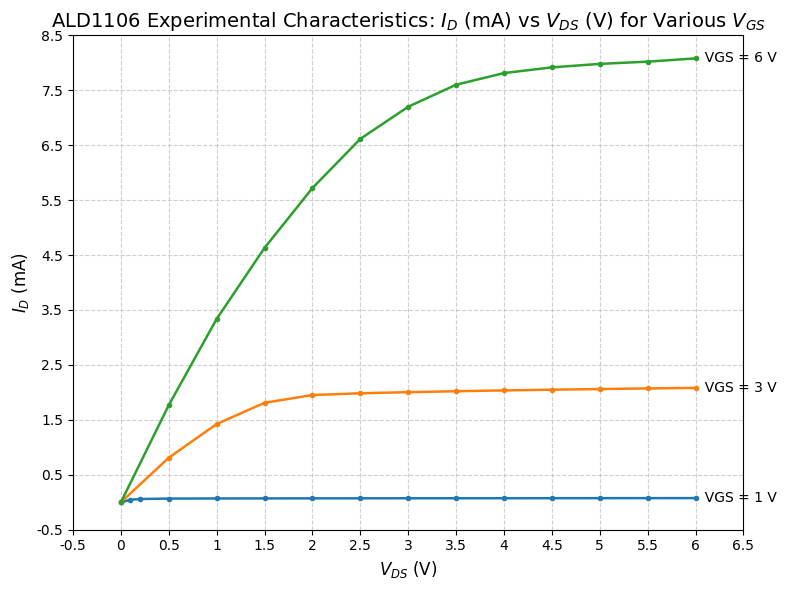

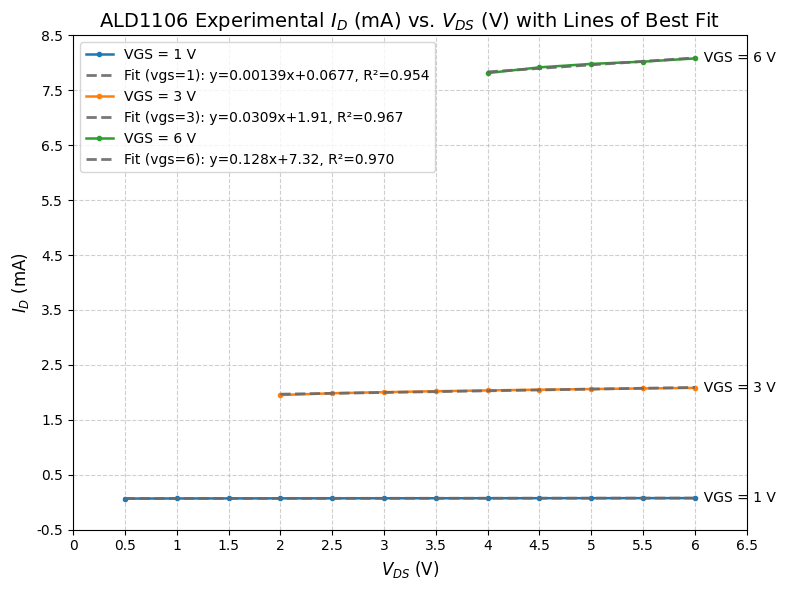

,vgs,vds,vrg,irg,vdd,slope,lambda
0,6,4.0,7.8130,0.007813,11.9,0.000128,0.016383
1,6,4.5,7.9170,0.007917,12.5,0.000128,0.016168
2,6,5.0,7.9800,0.007980,13.1,0.000128,0.016040
3,6,5.5,8.0210,0.008021,13.6,0.000128,0.015958
4,6,6.0,8.0800,0.008080,14.2,0.000128,0.015842
5,3,2.0,1.9520,0.001952,4.0,0.000031,0.015830
6,3,2.5,1.9840,0.001984,4.5,0.000031,0.015575
7,3,3.0,2.0040,0.002004,5.0,0.000031,0.015419
8,3,3.5,2.0210,0.002021,5.5,0.000031,0.015289
9,3,4.0,2.0360,0.002036,6.0,0.000031,0.015177


In [ ]:
# Plotting experimental NMOS characteristics

title  = r"ALD1106 Experimental Characteristics: $I_D$ (mA) vs $V_{DS}$ (V) for Various $V_{GS}$"
x_ax   = r"$V_{DS}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('nmos/nmos_id_vgs_exp.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vgs', x_col='vds', y_col='irg', y_scale=1000.0)

# Generating plots with lines of best fit for lambda calculation

nmos_exp = pd.read_csv('nmos/nmos_id_vgs_exp.csv')

vds_thresholds = {6.0: 4.0, 3.0: 2.0, 1.0: 0.5}

def filter_by_vds_thresholds(df, vgs_col, vds_col, thresholds):
    """
    Filters the dataframe so that for each VGS value in `thresholds`,
    only rows where VDS is greater than or equal to the corresponding threshold are kept.
    """
    filtered = []
    for vgs_val, vds_min in thresholds.items():
        subset = df[(df[vgs_col] == vgs_val) & (df[vds_col] >= vds_min)]
        filtered.append(subset)
    return pd.concat(filtered, ignore_index=True)

filtered_df = filter_by_vds_thresholds(nmos_exp, "vgs", "vds", vds_thresholds)

# With linear best-fit lines (per group):
plot_family_curves(
    r"ALD1106 Experimental $I_D$ (mA) vs. $V_{DS}$ (V) with Lines of Best Fit",
    r"$V_{DS}$ (V)", r"$I_D$ (mA)",
    filtered_df, group_col="vgs", x_col="vds", y_col="irg",
    y_scale=1000.0,
    add_best_fit=True,      # <— new, optional
    fit_degree=1,           # linear
)

# Hard coding the slopes for the lines of best fit
vgs_slopes = {1: .00139, 3: .0309, 6: .128}
vgs_slopes  = {k: v/1000 for k, v in vgs_slopes.items()}

# Calculating the lambda for the nmos

# Add slope column based on VGS
filtered_df["slope"] = filtered_df["vgs"].map(vgs_slopes)

# Add lambda column (slope / irg)
filtered_df["lambda"] = filtered_df["slope"] / filtered_df["irg"]

final_lambda = filtered_df['lambda'].mean()
print(final_lambda)

filtered_df

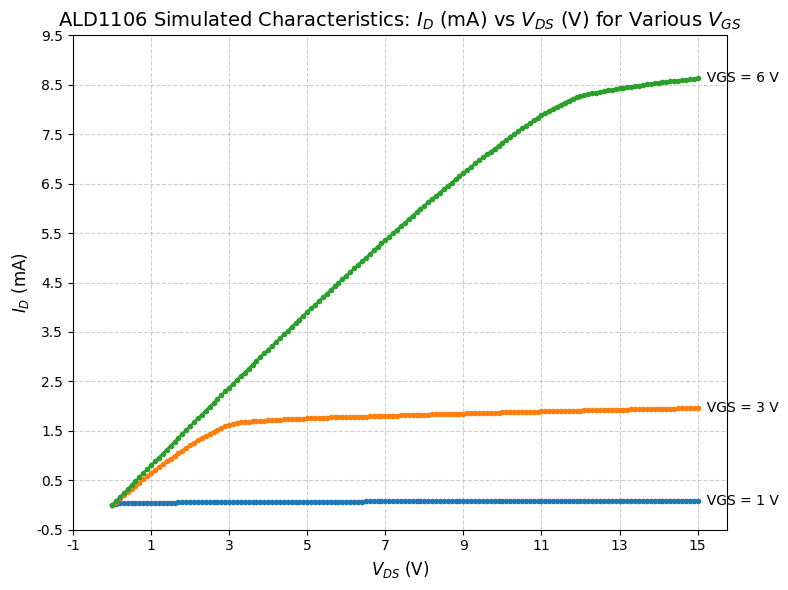

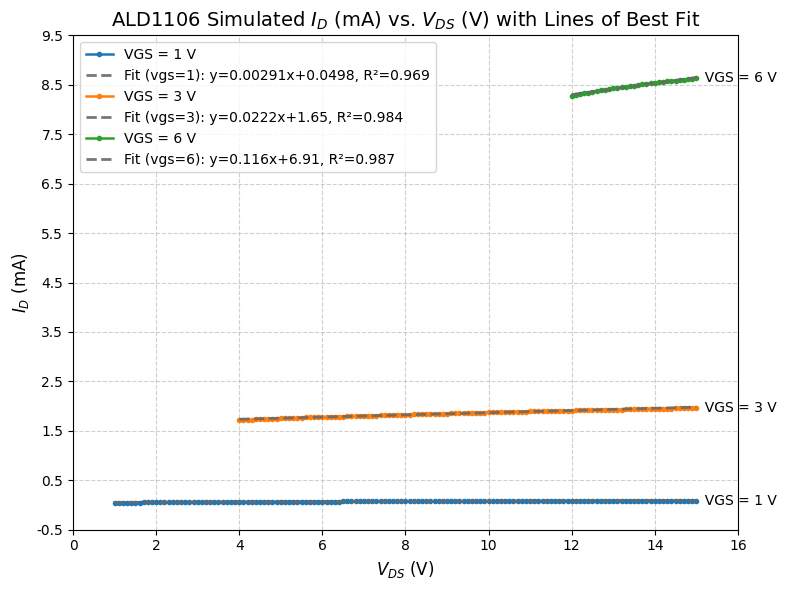

0.017971042711630286


In [6]:
# Plotting Simulated NMOS characteristics

title  = r"ALD1106 Simulated Characteristics: $I_D$ (mA) vs $V_{DS}$ (V) for Various $V_{GS}$"
x_ax   = r"$V_{DS}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('nmos/data_sim_nmos_id_vgs.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vgs', x_col='vds', y_col='irg', y_scale=1000.0)

# Generating plots with lines of best fit for lambda calculation

nmos_sim = pd.read_csv('nmos/data_sim_nmos_id_vgs.csv')

vds_thresholds = {6.0: 12.0, 3.0: 4.0, 1.0: 1.0}

def filter_by_vds_thresholds(df, vgs_col, vds_col, thresholds):
    """
    Filters the dataframe so that for each VGS value in `thresholds`,
    only rows where VDS is greater than or equal to the corresponding threshold are kept.
    """
    filtered = []
    for vgs_val, vds_min in thresholds.items():
        subset = df[(df[vgs_col] == vgs_val) & (df[vds_col] >= vds_min)]
        filtered.append(subset)
    return pd.concat(filtered, ignore_index=True)

filtered_df = filter_by_vds_thresholds(nmos_sim, "vgs", "vds", vds_thresholds)

# With linear best-fit lines (per group):
plot_family_curves(
    r"ALD1106 Simulated $I_D$ (mA) vs. $V_{DS}$ (V) with Lines of Best Fit",
    r"$V_{DS}$ (V)", r"$I_D$ (mA)",
    filtered_df, group_col="vgs", x_col="vds", y_col="irg",
    y_scale=1000.0,
    add_best_fit=True,      # <— new, optional
    fit_degree=1,           # linear
)

# Hard coding the slopes for the lines of best fit
vgs_slopes = {1: .00139, 3: .0309, 6: .128}
vgs_slopes  = {k: v/1000 for k, v in vgs_slopes.items()}

# Calculating the lambda for the nmos

# Add slope column based on VGS
filtered_df["slope"] = filtered_df["vgs"].map(vgs_slopes)

# Add lambda column (slope / irg)
filtered_df["lambda"] = filtered_df["slope"] / filtered_df["irg"]

final_lambda = filtered_df['lambda'].mean()
print(final_lambda)

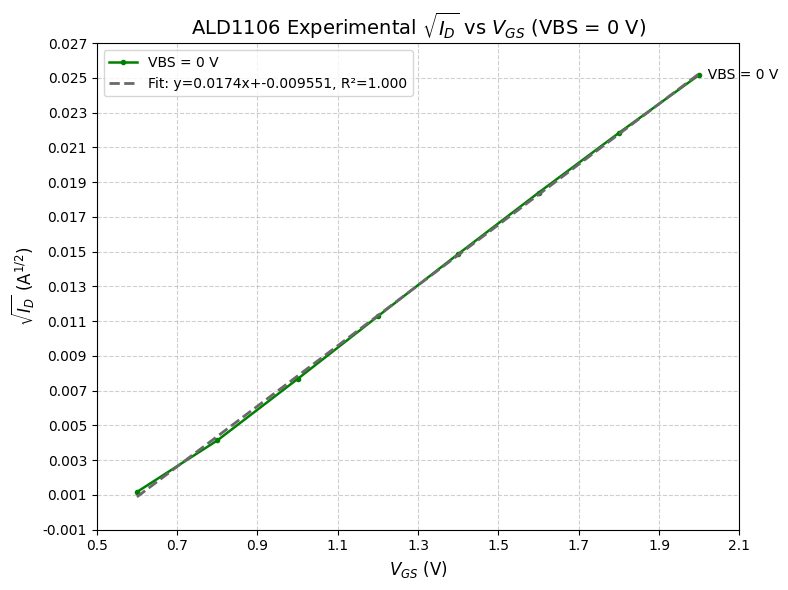

In [7]:
# Plotting experimental square root ID versus VGS for 0 VBS

sqrt_id_vgs_exp = pd.read_csv('nmos/data_exp_nmos_sqrt_id_vbs.csv')

# --- assume you already have: sqrt_id_vgs_exp DataFrame ---
# Keep only VBS = 0 and VGS > 0.6 to make a cleaner linear graph
vbs0_df = sqrt_id_vgs_exp[(sqrt_id_vgs_exp["vbs"] == 0) &
                          (sqrt_id_vgs_exp["vgs"] >= 0.6)].copy()
# vbs0_df = sqrt_id_vgs_exp[(sqrt_id_vgs_exp["vbs"] == 0)].copy()

# ----- helpers copied from your styling -----
def _nice_step(raw_step: float) -> float:
    if raw_step <= 0 or not np.isfinite(raw_step):
        return 1.0
    exp  = np.floor(np.log10(raw_step))
    frac = raw_step / (10**exp)
    for m in (1, 2, 2.5, 5, 10):
        if frac <= m:
            return m * (10**exp)
    return 10**(exp + 1)

def label_every_grid(ax, target_major_ticks: int = 30) -> None:
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xstep = _nice_step((xmax - xmin) / max(target_major_ticks, 2))
    ystep = _nice_step((ymax - ymin) / max(target_major_ticks, 2))
    ax.xaxis.set_major_locator(MultipleLocator(xstep))
    ax.yaxis.set_major_locator(MultipleLocator(ystep))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.grid(True, which='major', linestyle='--', alpha=0.6)

# ----- plot + best fit -----
fig, ax = plt.subplots(figsize=(8, 6))

# data curve
ax.plot(vbs0_df["vgs"], vbs0_df["sqrt(irg)"],
        marker='o', markersize=3, linewidth=1.8,
        color='green', label="VBS = 0 V")

# black label for the curve (not the fit)
ax.text(vbs0_df["vgs"].iloc[-1], vbs0_df["sqrt(irg)"].iloc[-1],
        "  VBS = 0 V", va='center', color='black')

# linear best fit (sqrt(Id) vs Vgs)
x = vbs0_df["vgs"].to_numpy()
y = vbs0_df["sqrt(irg)"].to_numpy()
m, b = np.polyfit(x, y, 1)
yhat = m*x + b
ss_res = np.sum((y - yhat)**2)
ss_tot = np.sum((y - y.mean())**2)
r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

xfit = np.linspace(x.min(), x.max(), 300)
yfit = m*xfit + b
ax.plot(xfit, yfit, linestyle='--', linewidth=2.0, color='dimgray',
        label=f"Fit: y={m:.4g}x+{b:.4g}, R²={r2:.3f}")

# styling (matches your plot_family_curves)
ax.set_title(r"ALD1106 Experimental $\sqrt{I_D}$ vs $V_{GS}$ (VBS = 0 V)", fontsize=14)
ax.set_xlabel(r"$V_{GS}$ (V)", fontsize=12)
ax.set_ylabel(r"$\sqrt{I_D}$ (A$^{1/2}$)", fontsize=12)
ax.grid(True, which='both', linestyle=':', alpha=0.25)
label_every_grid(ax, target_major_ticks=30)

# every other tick
xt, yt = ax.get_xticks(), ax.get_yticks()
if len(xt) > 2: ax.set_xticks(xt[::2])
if len(yt) > 2: ax.set_yticks(yt[::2])

ax.legend(fontsize=10, loc='best')
fig.tight_layout()
plt.show()


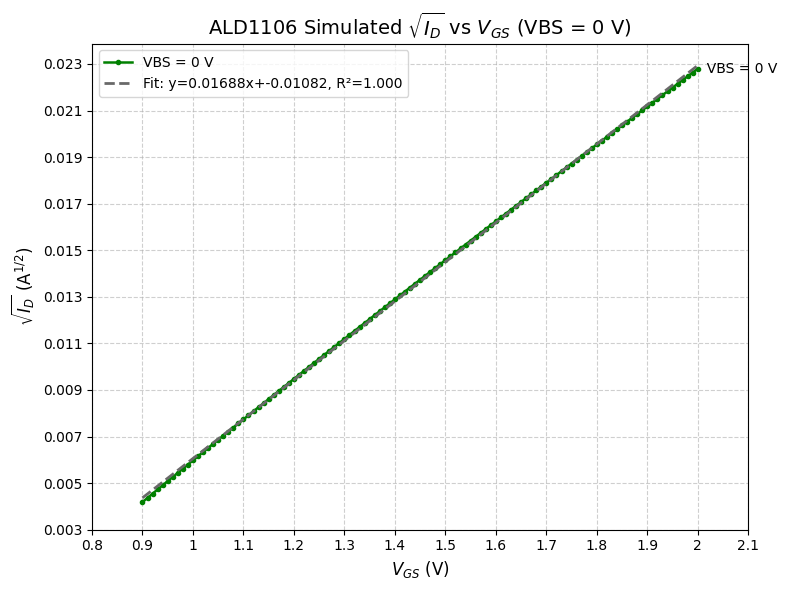

In [8]:
# Plotting experimental square root ID versus VGS for 0 VBS

sqrt_id_vgs_sim = pd.read_csv('nmos/data_sim_nmos_sqrt_id_vbs.csv')

# --- assume you already have: sqrt_id_vgs_exp DataFrame ---
# Keep only VBS = 0 and VGS > 0.6
vbs0_df = sqrt_id_vgs_sim[(sqrt_id_vgs_sim["vbs"] == 0) &
                          (sqrt_id_vgs_sim["vgs"] >= 0.9)].copy()

# ----- helpers copied from your styling -----
def _nice_step(raw_step: float) -> float:
    if raw_step <= 0 or not np.isfinite(raw_step):
        return 1.0
    exp  = np.floor(np.log10(raw_step))
    frac = raw_step / (10**exp)
    for m in (1, 2, 2.5, 5, 10):
        if frac <= m:
            return m * (10**exp)
    return 10**(exp + 1)

def label_every_grid(ax, target_major_ticks: int = 30) -> None:
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xstep = _nice_step((xmax - xmin) / max(target_major_ticks, 2))
    ystep = _nice_step((ymax - ymin) / max(target_major_ticks, 2))
    ax.xaxis.set_major_locator(MultipleLocator(xstep))
    ax.yaxis.set_major_locator(MultipleLocator(ystep))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.grid(True, which='major', linestyle='--', alpha=0.6)

# ----- plot + best fit -----
fig, ax = plt.subplots(figsize=(8, 6))

# data curve
ax.plot(vbs0_df["vgs"], vbs0_df["sqrt(irg)"],
        marker='o', markersize=3, linewidth=1.8,
        color='green', label="VBS = 0 V")

# black label for the curve (not the fit)
ax.text(vbs0_df["vgs"].iloc[-1], vbs0_df["sqrt(irg)"].iloc[-1],
        "  VBS = 0 V", va='center', color='black')

# linear best fit (sqrt(Id) vs Vgs)
x = vbs0_df["vgs"].to_numpy()
y = vbs0_df["sqrt(irg)"].to_numpy()
m, b = np.polyfit(x, y, 1)
yhat = m*x + b
ss_res = np.sum((y - yhat)**2)
ss_tot = np.sum((y - y.mean())**2)
r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

xfit = np.linspace(x.min(), x.max(), 300)
yfit = m*xfit + b
ax.plot(xfit, yfit, linestyle='--', linewidth=2.0, color='dimgray',
        label=f"Fit: y={m:.4g}x+{b:.4g}, R²={r2:.3f}")

# styling (matches your plot_family_curves)
ax.set_title(r"ALD1106 Simulated $\sqrt{I_D}$ vs $V_{GS}$ (VBS = 0 V)", fontsize=14)
ax.set_xlabel(r"$V_{GS}$ (V)", fontsize=12)
ax.set_ylabel(r"$\sqrt{I_D}$ (A$^{1/2}$)", fontsize=12)
ax.grid(True, which='both', linestyle=':', alpha=0.25)
label_every_grid(ax, target_major_ticks=30)

# every other tick
xt, yt = ax.get_xticks(), ax.get_yticks()
if len(xt) > 2: ax.set_xticks(xt[::2])
if len(yt) > 2: ax.set_yticks(yt[::2])

ax.legend(fontsize=10, loc='best')
fig.tight_layout()
plt.show()


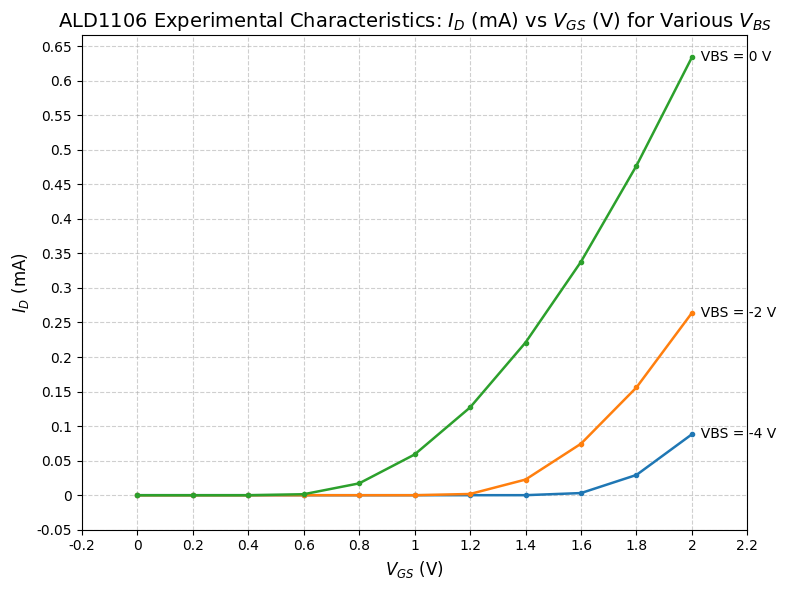

In [9]:
# Plotting experimental NMOS vbs characteristics

title  = r"ALD1106 Experimental Characteristics: $I_D$ (mA) vs $V_{GS}$ (V) for Various $V_{BS}$"
x_ax   = r"$V_{GS}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('nmos/nmos_id_vbs_exp.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vbs', x_col='vgs', y_col='irg', y_scale=1000.0)

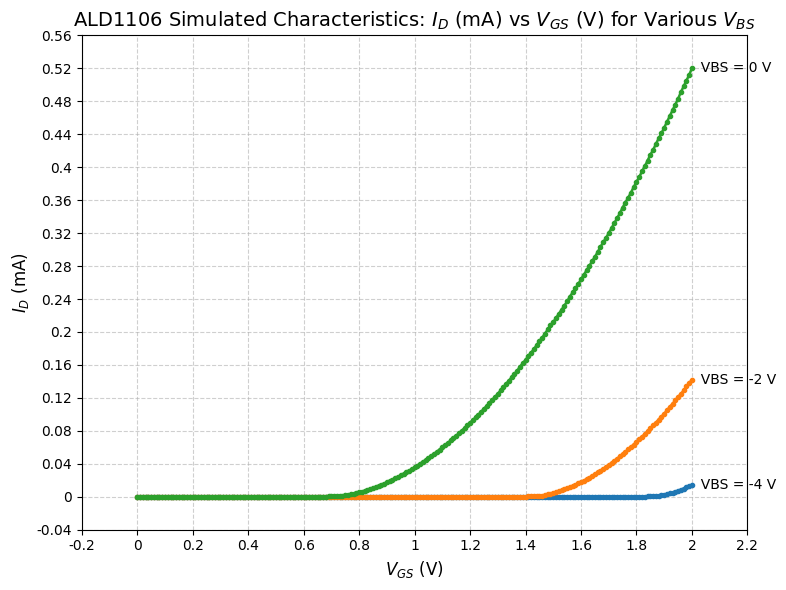

In [10]:
# Plotting simulated NMOS vbs characteristics

title  = r"ALD1106 Simulated Characteristics: $I_D$ (mA) vs $V_{GS}$ (V) for Various $V_{BS}$"
x_ax   = r"$V_{GS}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('nmos/data_sim_nmos_id_vbs.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vbs', x_col='vgs', y_col='irg', y_scale=1000.0)